# setup

In [1]:
import socket
import os

hostname = socket.gethostname()
if hostname == 'simurgh':
    os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-b5356651-0d8e-5cd1-bdf3-ccbb8b221031"
    
import time
import importlib
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TerminateOnNaN
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from tqdm.keras import TqdmCallback
import pandas as pd
import arviz as az
import netCDF4 as nc
import load_ppe_fun as lp
import tuning_fun as tu
import MCMC_fun as mf
import emulator_fun as ef
import util_fun as uf
import seaborn as sns

2025-10-29 04:09:26.516183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761710966.654231 1461690 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761710966.689560 1461690 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761710966.975061 1461690 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761710966.975079 1461690 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761710966.975081 1461690 computation_placer.cc:177] computation placer alr

In [2]:
# set up and check if GPU is being used

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
        #     tf.config.experimental.set_virtual_device_configuration(
        #     gpu,
        #     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=20480)]
        # )
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print(gpus)

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

Physical devices cannot be modified after being initialized
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# HP tuning

## pre-processing

In [10]:
importlib.reload(ef)

<module 'emulator_fun' from '/pscratch/sd/a/arthurhu/BOSS_PPE/emulator_fun.py'>

In [11]:
run_name = 'fullmp_ppe_KiD_log_r1_custom_lhs_momval_pratespec_sf3layers'
filename = run_name + '_N2500.nc'
var_select = None
# var_select = ['M0_path_last2hrmean', 'M3_path_last2hrmean', 'M4_path_last2hrmean', 'M6_path_last2hrmean', 
#               'prate_dm_last2hrmean', 'prate_dm_last2hrstd',
#               'sfM0_10m_last2hrmean', 'sfM3_10m_last2hrmean', 'sfM4_10m_last2hrmean', 'sfM6_10m_last2hrmean',
#               'sfM0_250m_last2hrmean', 'sfM3_250m_last2hrmean', 'sfM4_250m_last2hrmean', 'sfM6_250m_last2hrmean',
              # 'sfM0_500m_last2hrmean', 'sfM3_500m_last2hrmean', 'sfM4_500m_last2hrmean', 'sfM6_500m_last2hrmean',
             # ]
params_train = ef.get_params(lp.nc_dir, filename)
transform_method = 'standard_scaler_asinh'
# transform_method = ['standard_scaler_asinh', 'standard_scaler_asinh', 'standard_scaler_asinh', 'standard_scaler_asinh', 
#                     'standard_scaler', 'standard_scaler', 
#                     'standard_scaler', 'standard_scaler',  'standard_scaler', 'standard_scaler', 
#                     'standard_scaler_asinh', 'standard_scaler_asinh', 'standard_scaler_asinh', 'standard_scaler_asinh', 
#                     'standard_scaler_asinh', 'standard_scaler_asinh', 'standard_scaler_asinh', 'standard_scaler_asinh']
var_limit_zero = 'prate_dm_last2hrmean'
throw_away_ratio = 0.9
x_train, x_val, y_train, y_val, tgt_data, _, tgt_initvar_matrix, ppe_info, scalers = \
    ef.get_train_val_tgt_data(lp.nc_dir, filename, params_train, transform_method, 
                              l_multi_output=False, set_nan_to_neg1001=True, 
                              var_select=var_select, 
                              var_limit_zero=var_limit_zero,
                              throw_away_ratio=throw_away_ratio,
                             )

nobs = ppe_info['nobs']
nvar = ppe_info['nvar']
npar = ppe_info['npar']
n_init = ppe_info['n_init']
nparam_init = ppe_info['nparam_init']
ppe_info

Transforming data...: 18it [00:00, 2083.38it/s]


{'n_init': np.int64(1),
 'nppe': 665,
 'nparam_init': 24,
 'nobs': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'ncases': 16,
 'nvar': 18,
 'npar': np.int64(23),
 'eff0s': array([1.85117040e+08, 2.74045531e-05, 1.27329680e-11, 1.26242364e-18,
        1.00000000e-08, 1.00000000e-08, 6.00568943e-05, 4.44370014e-10,
        3.51552601e-18, 1.06424125e-24, 4.17263151e-14, 4.58816454e-27,
        1.64185680e-28, 9.44838332e-37, 9.59702612e-07, 4.34267715e-19,
        4.01486424e-21, 2.15393254e-29]),
 'var_constraints': ['M0_path_last2hrmean',
  'M3_path_last2hrmean',
  'M4_path_last2hrmean',
  'M6_path_last2hrmean',
  'prate_dm_last2hrmean',
  'prate_dm_last2hrstd',
  'sfM0_10m_last2hrmean',
  'sfM3_10m_last2hrmean',
  'sfM4_10m_last2hrmean',
  'sfM6_10m_last2hrmean',
  'sfM0_250m_last2hrmean',
  'sfM3_250m_last2hrmean',
  'sfM4_250m_last2hrmean',
  'sfM6_250m_last2hrmean',
  'sfM0_500m_last2hrmean',
  'sfM3_500m_last2hrmean',
  'sfM4_500m_last2hrmean',
  'sfM6_500m_last2hrmean

np.float64(1.8081124278685998)

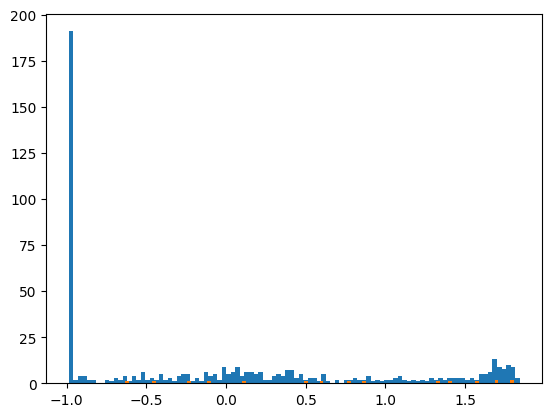

In [13]:
_ = plt.hist(y_train['prate_dm_last2hrmean'], bins=100)
_ = plt.hist(tgt_data[4], bins=100)
np.max(tgt_data[4])

Next, try out different ML architectures...

## CRPS

In [48]:
proj_name = f'crps3_{run_name}'

if isinstance(transform_method, str):
    proj_name += f'_{transform_method}'
else:
    proj_name += '_mixed_transform_throw'

if throw_away_ratio > 0:
    proj_name += f'_throw_{throw_away_ratio}'

if var_select is not None: 
    proj_name += "".join([varstr[0] for varstr in var_select])

print('proj_name:', proj_name)

varcons = ppe_info['var_constraints']
y_train_nopres = {k: v for k, v in y_train.items() if 'presence_' not in k}
y_val_nopres = {k: v for k, v in y_val.items() if 'presence_' not in k}

nparam_init = ppe_info['nparam_init']
tuner = kt.RandomSearch(
    lambda hp: tu.build_reg_crps_model(hp, nparam_init, varcons, nobs),
    objective="val_loss",
    max_trials=100,
    directory='hp_tuning/crps',
    project_name=proj_name,
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# under-weight the cases with less rain
# choose the exact output name of rain rate
RR_KEY = 'prate_dm_last2hrmean'

# constants used to transform rain targets
ivar = 4
ASINH_SCALE = ppe_info['eff0s'][ivar]
T_MEAN = scalers['y'][ivar].mean_
T_STD  = scalers['y'][ivar].scale_
RR_THR_RAW = 1e-5

sw_train = ef.make_weights_dict(
    y_train_nopres, RR_KEY, RR_THR_RAW, ASINH_SCALE, T_MEAN, T_STD,
    w_zero=0.2, w_pos=1.0, smooth_alpha=6.0  # hyperparameters, tweak as needed
)
sw_val = ef.make_weights_dict(
    y_val_nopres, RR_KEY, RR_THR_RAW, ASINH_SCALE, T_MEAN, T_STD,
    w_zero=0.2, w_pos=1.0, smooth_alpha=6.0
)

tuner.search(
    x_train,
    y_train_nopres,
    sample_weight=sw_train,
    epochs=25,
    # validation_data=(x_val, y_val_nopres),
    validation_data=(x_val, y_val_nopres, sw_val),
    callbacks=([stop_early, TerminateOnNaN()])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)
best_model.summary()

Trial 100 Complete [00h 00m 46s]
val_loss: 6.856136322021484

Best val_loss So Far: 6.317254543304443
Total elapsed time: 01h 38m 09s


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │      6,400 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 160)       │     41,120 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │     41,216 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M0_path_last2hrmean │ (None, 2)         │        514 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M3_path_last2hrmean │ (None, 2)         │        514 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M4_path_last2hrmean │ (None, 2)         │        514 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M6_path_last2hrmean │ (None, 2)         │        514 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prate_dm_last2hrme… │ (None, 2)         │        514 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prate_dm_last2hrstd │ (None, 2)         │        514 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sfM0_10m_last2hrme… │ (None, 2)         │        514 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sfM0_250m_last2hrm… │ (None, 2)         │        514 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sfM0_500m_last2hrm… │ (None, 2)         │        514 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sfM3_10m_last2hrme… │ (None, 2)         │        514 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sfM3_250m_last2hrm… │ (None, 2)         │        514 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sfM3_500m_last2hrm… │ (None, 2)         │        514 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sfM4_10m_last2hrme… │ (None, 2)         │        514 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sfM4_250m_last2hrm… │ (None, 2)         │        514 │ dense_7[0][0]   

 Total params: 97,988 (382.77 KB)

 Trainable params: 97,988 (382.77 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)

history = best_model.fit(
    x=x_train,
    y=y_train_nopres,
    epochs=1000,
    verbose=0,
    validation_data=(x_val, y_val_nopres),
    callbacks=[TqdmCallback(verbose=1), stop_early]
)

# save model:
best_model.save(f'models/{proj_name}.keras')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

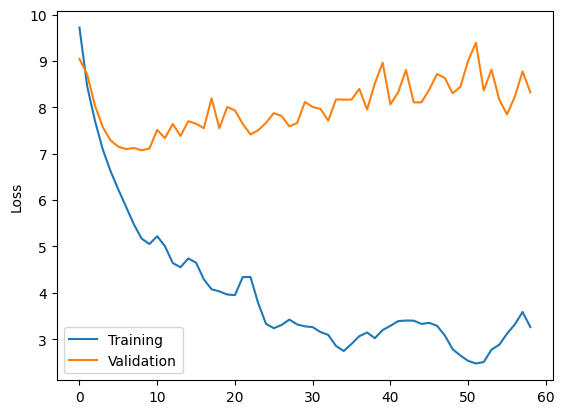

In [50]:
plt.figure()
plt.plot(history.epoch, history.history['loss'], label='Training')
plt.plot(history.epoch, history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.legend()

## multi-output (explicit) model

In [82]:
%%skip
proj_name = 'multioutput_unc_' + run_name + '_' + transform_method
if var_select is not None: 
    proj_name += "".join([varstr[0] for varstr in var_select])
    print('proj_name:', proj_name)
    
varcons = ppe_info['var_constraints']
nparam_init = ppe_info['nparam_init']
tuner = kt.RandomSearch(
    lambda hp: tu.build_classreg_unc_model(hp, nparam_init, varcons, nobs),
    objective="val_loss",
    max_trials=25,
    directory='hp_tuning/multi-output',
    project_name=proj_name,
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    x_train,
    y_train,
    epochs=25,
    validation_data=(x_val, y_val),
    callbacks=([stop_early, TerminateOnNaN()])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)
best_model.summary()

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)

history = best_model.fit(
    x=x_train,
    y=y_train,
    epochs=10000,
    verbose=0,
    validation_data=(x_val, y_val),
    callbacks=[TqdmCallback(verbose=1), stop_early]
)

# save model:
best_model.save(f'models/{proj_name}.keras')

In [83]:
%%skip
plt.figure()
plt.plot(history.epoch, history.history['loss'], label='Training')
plt.plot(history.epoch, history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.legend()

## validation

In [20]:
# proj_name = 'crps_NCE_predNc_actwidth_dfl0.5_offline_last2hrmean_standard_scaler_asinh.keras'
# best_model = tf.keras.models.load_model(f'models/{proj_name}', compile=False)

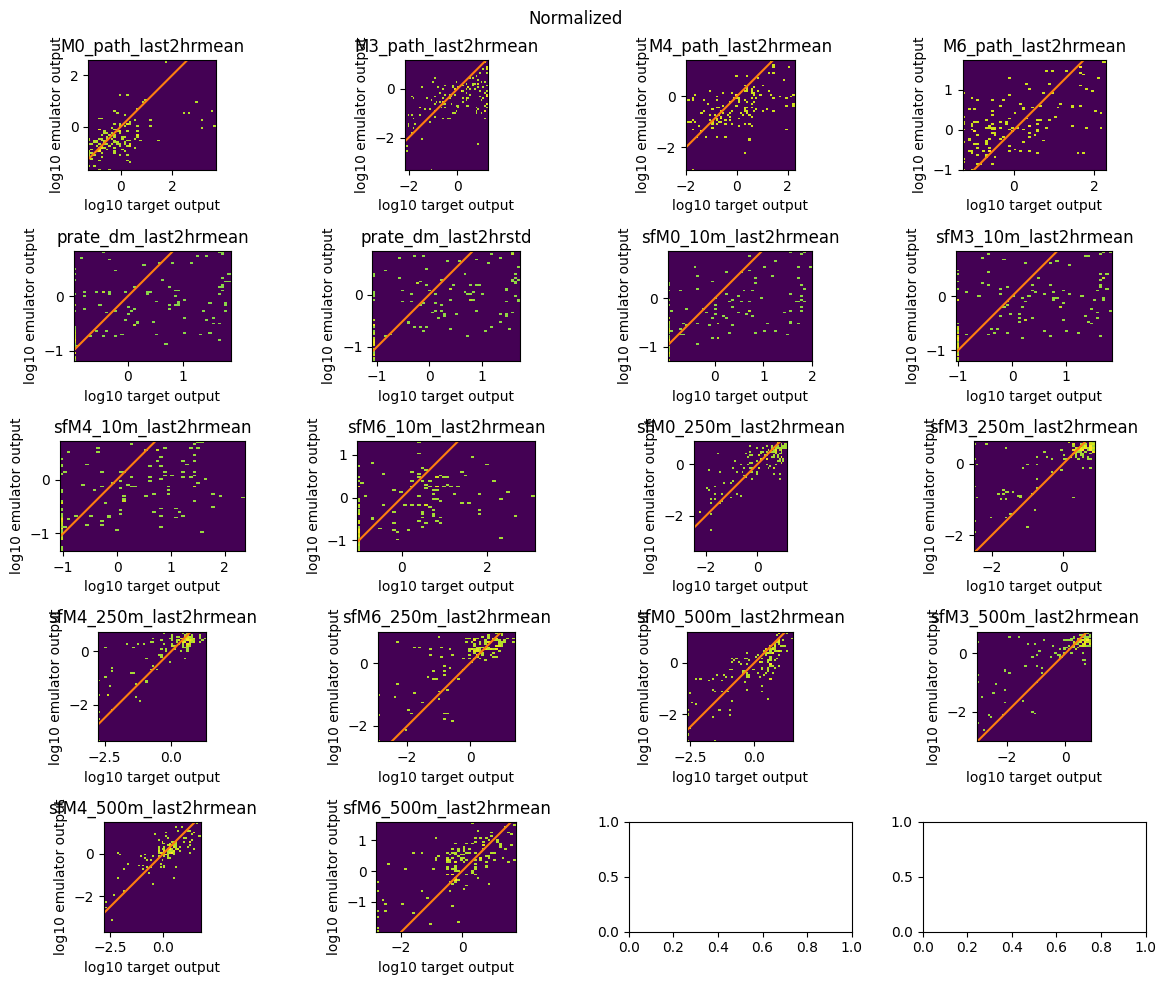

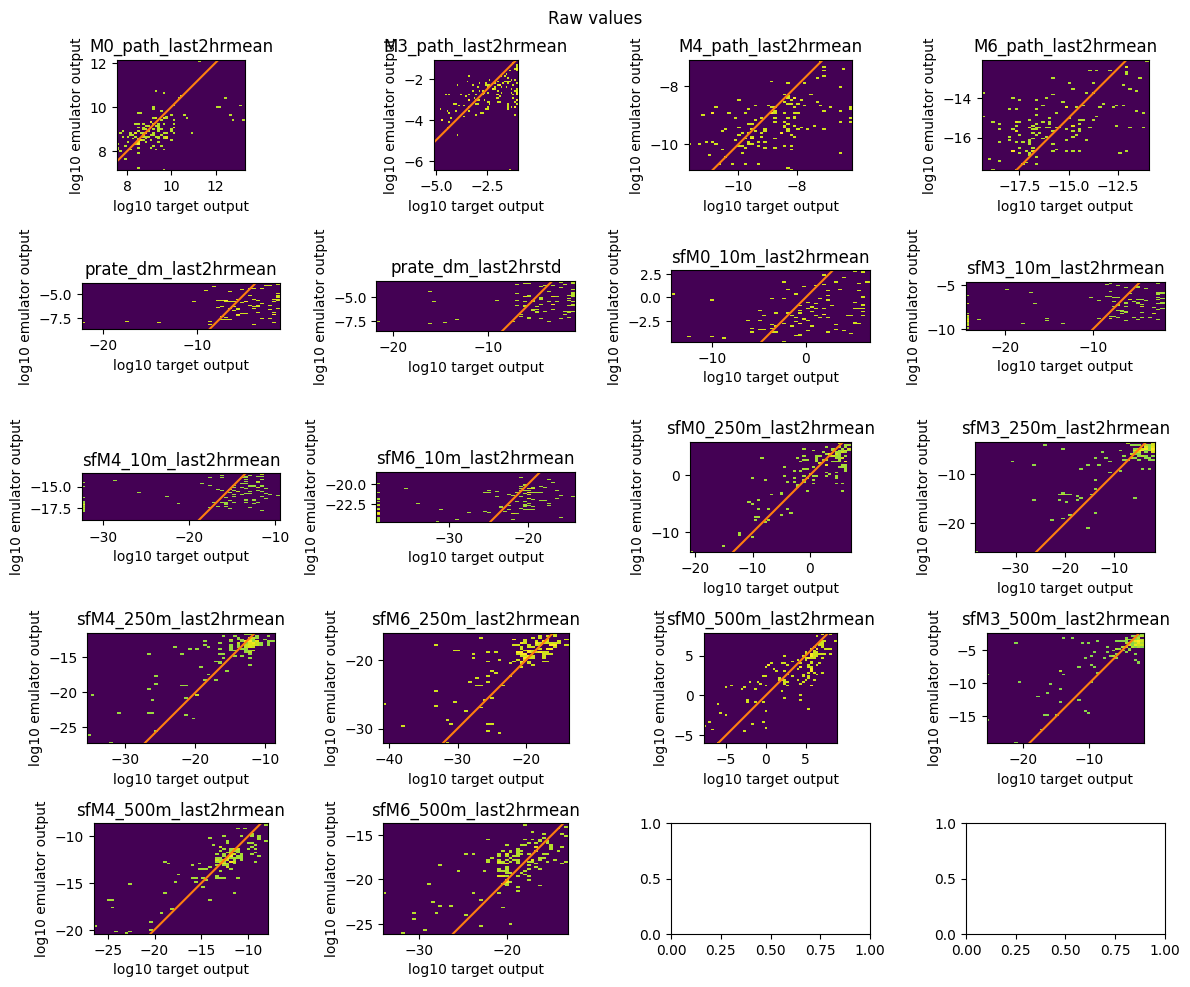

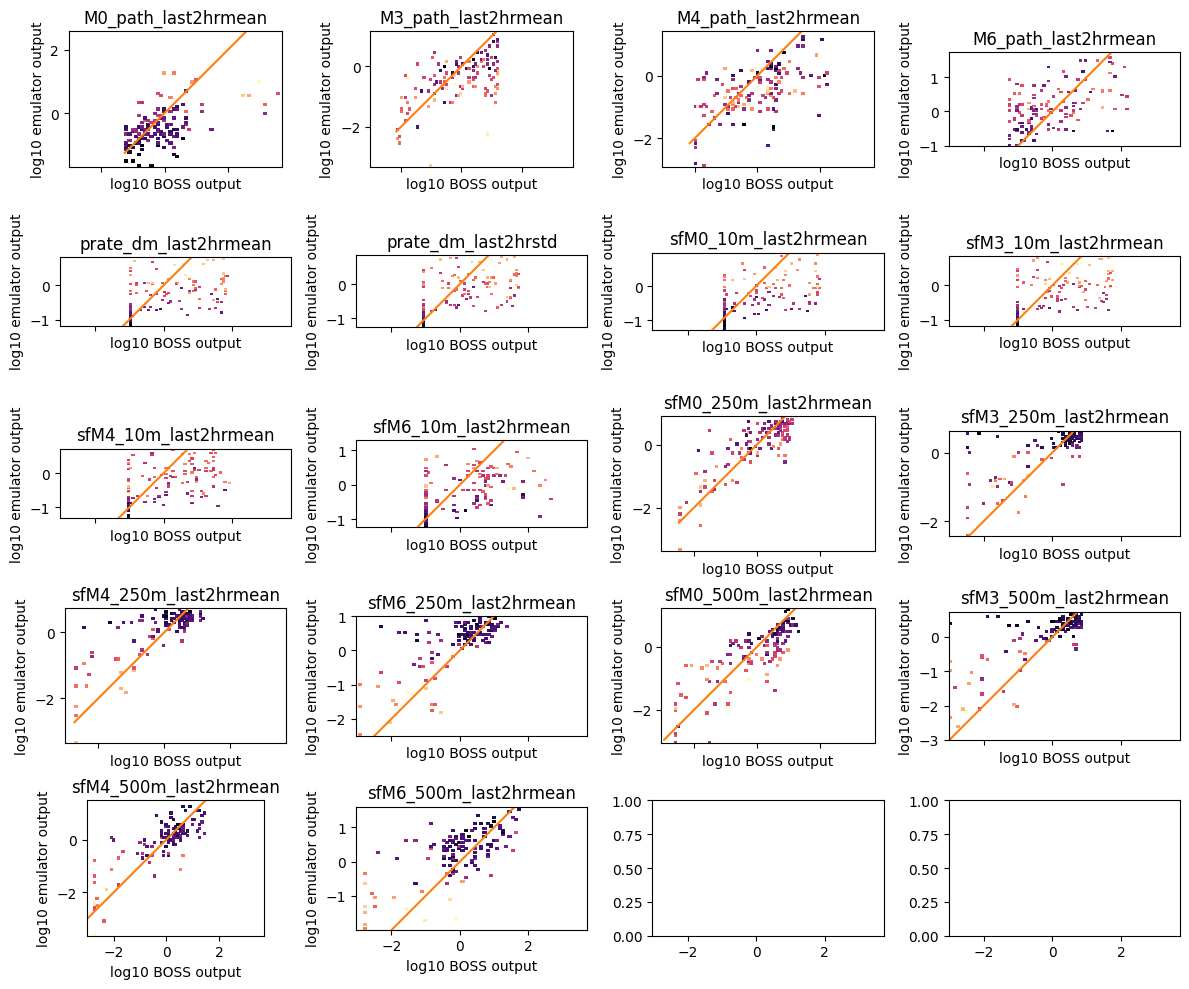

In [51]:
importlib.reload(ef)
# ef.plot_emulator_results(x_train, y_train, best_model, ppe_info, transform_method, scalers, l_plot_uncertainty=True, l_plot_scatter=False)
ef.plot_emulator_results(x_val, y_val, best_model, ppe_info, transform_method, scalers, l_plot_uncertainty=True, l_plot_scatter=False)

# MCMC

## setup

In [19]:
# proj_name = 'crps_fullmp_ppe_KiD_sed_r1_momval_pratespec_sf3layers_standard_scaler_asinh'
# best_model = tf.keras.models.load_model('models/' + proj_name + '.keras', compile=False)
# plt.hist(params_train['vals'][:,2])

In [20]:
# MCMC
nchains = 12
num_burnin_steps = 5000
num_samples = 10000

# log prob function related
tau = 0.05
inflate_factor = .3

In [21]:
param_interest_idx = params_train['param_interest_idx']

orig_param_csv = f'{lp.param_dir}param_fullmp_ppe_KiD_log_momval_pratespec_sf3layers_crps.csv'
# orig_param_csv = f'{lp.param_dir}param_fullmp_ppe_KiD_log_momval_pratespec_sf3layers_crps.csv'
target_param_csv = f'{lp.param_dir}param_fullmp_ppe_KiD_log_momval_pratespec_sf3layers_crps.csv'

param_table = pd.read_csv(orig_param_csv)
param_names = param_table.columns[1+param_interest_idx].to_list()
all_param_names = param_table.columns[1:].to_list()

target_param_table = pd.read_csv(target_param_csv)

all_param_mean = param_table.values[0, 1:].astype(np.float32)
param_mean = param_table.values[0, 1+param_interest_idx].astype(np.float32)
param_std = param_table.values[2, 1+param_interest_idx].astype(np.float32)
target_param_mean = target_param_table.values[0, 1+param_interest_idx].astype(np.float32)
nparam = len(param_names)

param_dict = {
    'param names': param_names, 
    'prior mean': param_mean, 
    'prior std': param_std,
    'target mean': target_param_mean,
    }

print_table = pd.DataFrame(param_dict)
print(print_table)

   param names  prior mean  prior std  target mean
0    a0coal_db  -88.483414  16.014278   -88.483414
1       bmcoal    0.053349   1.847258     0.053349
2      bn0coal    0.589379   1.415633     0.589379
3      bnxcoal    2.732147   1.755055     2.732147
4      bnycoal    5.166839   1.935561     5.166839
5      bx0coal    2.376075   1.923735     2.376075
6      bxxcoal    3.022325   1.713603     3.022325
7      bxycoal    2.561744   2.341724     2.561744
8      by0coal    1.719374   2.453771     1.719374
9      byxcoal    5.536561   1.554501     5.536561
10     byycoal    4.032137   2.573264     4.032137
11  mtrans0_db   -3.596570  19.693342    -3.596570
12    afall_db   17.134422  13.850052    17.134422
13      bnfall   -5.339467   1.245903    -5.339467
14     bx0fall    0.272786   1.629550     0.272786
15     bx3fall   -3.865487   1.786454    -3.865487
16     bxxfall   -0.543629   1.651713    -0.543629
17     bxyfall   -0.112963   1.462216    -0.112963
18     by0fall    0.736423   1.

In [22]:
tgt_data_tf32 = tf.concat([tf.cast(x, tf.float32) for x in tgt_data],axis=-1)

tgt_sim_ics = np.concatenate(tgt_initvar_matrix, axis=1)
nvar = len(ppe_info['var_constraints'])
n_tgt_ics = tgt_data[0].shape[0]

IC_with_dummy = np.concatenate((tgt_sim_ics, np.zeros([n_tgt_ics, npar])), axis=1)
IC_norm = scalers['x'].transform(IC_with_dummy)[:,:n_init].astype('float32')
IC_norm_3d = tf.tile(IC_norm[None, :, :], [nchains, 1, 1])
batch_size = nchains * n_tgt_ics
tgt_data_tf32_chain = tf.tile(tgt_data_tf32[None, :, :], [nchains, 1, 1])
varcons = ppe_info['var_constraints']

lambda_emu_i = tf.Variable(0., dtype=tf.float32)
sigma0_i     = tf.Variable(0., dtype=tf.float32)
unc_names = ['mismatch']

# testing

target_param_with_IC = np.concatenate([[2e7], target_param_mean])
target_param_norm = tf.cast(scalers['x'].transform(target_param_with_IC.reshape(1, -1)), tf.float32)

## set up log prob function

In [23]:
tfd = tfp.distributions
tfb = tfp.bijectors
tfs = tfp.experimental.stats

def get_BOSSemu_lp(params_sigma, l_diag=False, use_loglik=True, l_learn_unc=True):
    emu_mu_list, emu_sigma_list, emu_pres_list = [], [], []
    sigma_list, obs_lp_list, y_true_safe_list, mu_safe_list = [], [], [], []
    
    # priors on parameters
    if l_learn_unc:
        # params, raw_lambda_emu, raw_sigma0 = tf.split(params_sigma, [npar, 1, 1], axis=-1)
        params, raw_sigma0 = tf.split(params_sigma, [npar, 1], axis=-1)
    else:
        params = params_sigma
    params_3d = tf.tile(params[:, None, :], [1, n_tgt_ics, 1])
    theta = tfb.Sigmoid().forward(params_3d)
    param_lp = tf.reduce_sum(tf.math.log(theta) + tf.math.log1p(-theta), axis=[1,2])

    if l_learn_unc:
        sigma0     = tf.exp(raw_sigma0)
        # lambda_emu = tf.exp(raw_lambda_emu)
        lp_hyp = tfd.Normal(0, 1.).log_prob(raw_sigma0)
        # lp_hyp = tfd.Normal(0, 1.).log_prob(raw_lambda_emu) + tfd.Normal(0, 1.).log_prob(raw_sigma0)

    if l_diag:
        # print('input:', params_3d[0,0,:].numpy())
        print('scaled parameters:', theta[0, 0, :].numpy())

    # likelihood
    input_norm3d = tf.concat([IC_norm_3d, theta], axis=-1) # nchains x n_tgt_ics x n_input
    input_norm2d  = tf.reshape(input_norm3d, [batch_size, nparam_init])
    y_emu = best_model(input_norm2d) # nvar * n_tgt_ics x nobs
    if type(y_emu) is dict:
        for i, varcon in enumerate(varcons):
            # set default presence value to 1 (true) if it's not a predicted by emulator (not by CRPS, yes by multioutput)
            pres = tf.ones([nchains, n_tgt_ics, nobs[i]], tf.float32)
            if f'presence_{varcon}' in y_emu.keys():
                pres   = tf.reshape(tf.cast(y_emu[f'presence_{varcon}'], tf.float32),
                                    [nchains, n_tgt_ics, nobs[i]])
            full   = tf.reshape(tf.cast(y_emu[varcon], tf.float32),
                                [nchains, n_tgt_ics, 2*nobs[i]])
            mu     = full[..., :nobs[i]]
            rawsig = full[..., nobs[i]:]  # raw scale; softplus later
            emu_pres_list.append(pres)
            emu_mu_list.append(mu)
            emu_sigma_list.append(tf.nn.softplus(rawsig))
            
        emu_pres_chain  = tf.concat([p for p in emu_pres_list],  axis=-1)   # [chain, ic, var] 
        emu_mu_chain    = tf.concat([p for p in emu_mu_list],    axis=-1)
        emu_sigma_chain = tf.concat([p for p in emu_sigma_list], axis=-1)
    else:
        raise ValueError('`y_emu` is not a dictionary. Not yet implemented.')

    for ichain in range(nchains):
        presence_pred = emu_pres_chain[ichain, ...]   # [nvar, n_ic, nobs]
        mu_pred       = emu_mu_chain[ichain, ...]
        sig_pred      = emu_sigma_chain[ichain, ...]
        y_true        = tgt_data_tf32                          # [nvar, n_ic, nobs]

        finite_mask = tf.math.is_finite(y_true)
        finite_w    = tf.stop_gradient(tf.cast(finite_mask, tf.float32))

        # soft presence gate (same as you had)
        thresh = tf.constant(0.1, tf.float32)
        tau    = tf.constant(0.05, tf.float32)
        w_soft = tf.sigmoid((presence_pred - thresh) / tau)

        w = finite_w * w_soft

        # safe tensors
        y_true_safe = tf.where(finite_mask, y_true, 0.0)
        mu_safe     = tf.where(finite_mask, mu_pred, 0.0)
        sigma_emu    = tf.where(finite_mask, sig_pred, 0.0)
        
        #  Weighted scale (avoid NaN when few points are active)
        eps    = tf.constant(1e-6, tf.float32)
        w_sum  = tf.reduce_sum(w) + eps
        resid  = mu_safe - y_true_safe
        mean_w = tf.reduce_sum(w * resid) / w_sum
        var_w  = tf.reduce_sum(w * tf.square(resid - mean_w)) / w_sum
        # sigma_eff = tf.sqrt(tf.square(resid) + tf.square(sigma_emu) + 1e-6)
        if l_learn_unc:
            sigma_eff = tf.sqrt(tf.square(sigma0[ichain]) + tf.square(sigma_emu))
            # sigma_eff = tf.sqrt(tf.square(sigma0[ichain]) + lambda_emu[ichain]**2 * tf.square(sigma_emu))
        else:
            sigma_eff = tf.sqrt(var_w)
            # sigma_eff = tf.sqrt(var_w + tf.square(sigma_emu))
        # sigma_eff = sigma_emu
        # print(tf.square(resid).shape, tf.square(sigma_emu).shape)
        # sigma_eff = sigma_emu
        # print('y_true std ~', float(tf.math.reduce_std(y_true_safe)))
        # print('|residual| rms ~', float(tf.sqrt(tf.reduce_mean(tf.square(mu_safe - y_true_safe)))))
        # print('sigma_eff mean/median ~',
        #       float(tf.reduce_mean(sigma_eff)), sigma0[ichain])
        
        if l_diag:
            sigma_list.append(sigma_eff)
            y_true_safe_list.append(y_true_safe)
            mu_safe_list.append(mu_safe)

        if use_loglik:
            # Weighted log-likelihood
            logpdf = tfd.Normal(loc=y_true_safe, scale=sigma_eff).log_prob(mu_safe)
            obs_lp_list.append(tf.reduce_sum(w * logpdf))
        else:
            # CRPS per point (univariate, closed form)
            crps = mf.gaussian_crps_per_point(y_true_safe, mu_safe, sigma_emu)  # [nvar, n_ic, nobs]
            score_chain = tf.reduce_sum(w * crps)   # average CRPS over active points
            obs_lp_list.append(-score_chain)
            
    obs_lp = tf.stack(obs_lp_list)                   # shape [nchains]
        
    if l_diag:
        print('param_lp:', param_lp.numpy().mean(), 'obs_lp:', inflate_factor * obs_lp.numpy().mean())
        if l_learn_unc:
            print('hyper parameter lp:', lp_hyp.numpy().mean())
        # return param_lp, obs_lp * inflate_factor, crps, w, y_true_safe, mu_pred
        return obs_lp_list, sigma_list, y_true_safe_list, mu_safe_list, resid, sigma_emu
    else:
        if l_learn_unc:
            return param_lp + obs_lp * inflate_factor + tf.squeeze(lp_hyp)
        else:
            return param_lp + obs_lp * inflate_factor

In [24]:
tf.random.set_seed(1)
# initial_state = tf.random.normal([nchains, npar], seed=1) * 0.1
sigma0_i_vec  = tf.fill([nchains, 1], sigma0_i)
lambda_emu_i_vec = tf.fill([nchains, 1], lambda_emu_i)
initial_state = tf.random.normal([nchains, npar], seed=1)
initial_state = tf.concat([initial_state, sigma0_i_vec], axis=1)
obs_lp_list, sigma_list, y_true_safe_list, mu_safe_list, resid, sigma_emu = get_BOSSemu_lp(initial_state, l_diag=True)

# test target
target_param_mean_2d = np.tile(target_param_mean, (n_tgt_ics, 1))
target_param_withIC = np.concatenate((tgt_sim_ics, target_param_mean_2d), axis=1)
target_pwIC_norm = scalers['x'].transform(target_param_withIC)
# target1d = tf.concat([tfb.Sigmoid().inverse(target_pwIC_norm[0,n_init:]), [0]], axis=0)
target1d = tfb.Sigmoid().inverse(target_pwIC_norm[0,n_init:])
target_chain = tf.cast(tf.tile(target1d[None, :], [nchains, 1]), tf.float32)
target_chain = tf.concat([target_chain, sigma0_i_vec], axis=1)
_ = get_BOSSemu_lp(target_chain, l_diag=True)

scaled parameters: [0.56999576 0.9158944  0.9072411  0.42344135 0.38993597 0.30849898
 0.54000455 0.41654184 0.6142907  0.22287238 0.7187622  0.2168608
 0.41780537 0.49786445 0.3793236  0.71317387 0.62491065 0.3326795
 0.8256969  0.5704297  0.54067326 0.49875095 0.32435048]
param_lp: -595.8789 obs_lp: -128.81818
hyper parameter lp: -0.9189386
scaled parameters: [0.20992273 0.44155243 0.26245594 0.5865533  0.86928624 0.6476128
 0.51224124 0.45527247 0.54573673 0.9439993  0.77791286 0.3009101
 0.79499006        nan 0.5065628  0.81465954 0.15216362 0.27576146
 0.89294964 0.69470185 0.57543755 0.6995199  0.61687267]
param_lp: nan obs_lp: nan
hyper parameter lp: -0.9189386


In [25]:
mu_safe_arr = np.array(mu_safe_list)
y_true_safe_arr = np.array(y_true_safe_list)

# results1d = tfb.Sigmoid().inverse(meanresults_incl_ics[0,n_init:])
# results_chain = tf.cast(tf.tile(results1d[None, :], [nchains, 1]), tf.float32)
# # results_chain = tf.concat([results_chain, sigma0_i_vec], axis=1)
# _ = get_BOSSemu_lp(results_chain, l_diag=True)

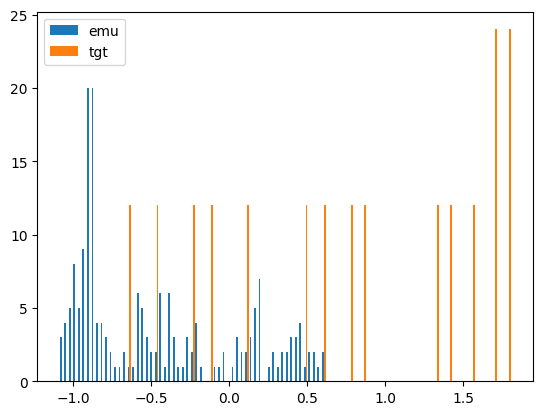

In [26]:
ivar = 4
# filtered = w.numpy().flatten()>0.5
mu_safe_arr = np.array(mu_safe_list)
y_true_safe_arr = np.array(y_true_safe_list)

emu_vs_tgt = [mu_safe_arr[:,:,ivar].flatten(), y_true_safe_arr[:,:,ivar].flatten()]
_ = plt.hist(emu_vs_tgt, bins=100)
plt.legend(['emu', 'tgt'])

# this is a histogram comparing range of target vs emulated constraint variables (in normalized scale). 
# having roughly the same range is indeed a good news, but otherwise it doesn't gaurantee a failure either. 
# could suggest either that the prior guess is way off or some structural issues. 

<Axes: ylabel='Count'>

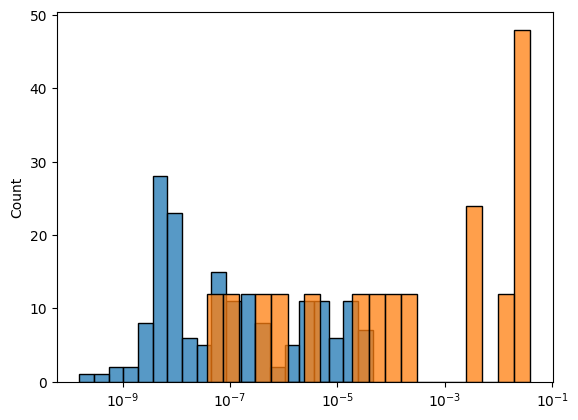

In [27]:
eff0s = ppe_info['eff0s']
mu_phys = ef.inverse_transform_data(mu_safe_arr[:,:,ivar], transform_method, scalers['y'][ivar], eff0=eff0s[ivar])
tgt_phys = ef.inverse_transform_data(y_true_safe_arr[:,:,ivar], transform_method, scalers['y'][ivar], eff0=eff0s[ivar])

sns.histplot(mu_phys.flatten(), bins=20, log_scale=True)
sns.histplot(tgt_phys.flatten(), bins=20, log_scale=True)

In [28]:
# Static diagonal preconditioner - pilot run to estimate sigma

pilot_hmc = tfp.mcmc.HamiltonianMonteCarlo(get_BOSSemu_lp, step_size=0.0005, num_leapfrog_steps=5)
@tf.function
def run_pilot_chain():
    return tfp.mcmc.sample_chain(num_results=100, num_burnin_steps=0,
                                   current_state=initial_state, kernel=pilot_hmc, 
                                   trace_fn=(lambda current_state, kernel_results: kernel_results), 
                                   seed=1)

z_pilot, kr_pilot = run_pilot_chain()

var = tf.math.reduce_variance(z_pilot, axis=[0,1]) + 1e-6
if initial_state.shape[-1] == npar:
    sigma = tf.sqrt(var)  # shape [npar]
elif initial_state.shape[-1] > npar:
    # dont precondition the uncertainty params
    nunc = initial_state.shape[-1] - npar
    sigma = tf.concat([tf.sqrt(var[:npar]), tf.ones(nunc)], axis=-1)
print(sigma)

ERROR! Session/line number was not unique in database. History logging moved to new session 842
tf.Tensor(
[0.9460326  1.0713958  1.1558362  0.509351   1.2347176  0.75815994
 0.7642282  1.0112162  0.96859586 0.91295326 0.9108293  0.7738837
 0.76985997 1.0291067  1.0989114  1.061094   1.0821505  0.9250617
 1.1294737  1.0865504  0.51134664 0.81768686 1.1214285  1.        ], shape=(24,), dtype=float32)


## actual run

In [29]:
stepsize = 0.1
bij = tfb.Blockwise([tfb.Sigmoid()] * npar)
rv0 = tfs.RunningVariance.from_stats(
    num_samples=tf.constant(0., initial_state.dtype),   # “empty” running variance
    mean=tf.zeros([npar], initial_state.dtype),
    variance=tf.ones([npar], initial_state.dtype),         # start with I
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(get_BOSSemu_lp, step_size=stepsize, num_leapfrog_steps=3)
DA = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=hmc,
        num_adaptation_steps=int(num_burnin_steps * 0.5),
        target_accept_prob=0.75,
        )

precond = tfp.bijectors.Scale(sigma)

TTK = tfp.mcmc.TransformedTransitionKernel(
    bijector=precond,
    inner_kernel=DA,
)

start = time.time()

@tf.function
def run_chain():
    return tfp.mcmc.sample_chain(num_results=num_samples,
        current_state=initial_state,   # or your initial_state
        kernel=TTK,
        num_burnin_steps=num_burnin_steps,
        trace_fn=(lambda current_state, kernel_results: kernel_results),
        seed=0)

samples, kr = run_chain()

end = time.time()
print(end-start)

206.3690845966339


acceptance rate: [0.7536 0.7312 0.7615 0.7526 0.7515 0.7664 0.7429 0.7457 0.7561 0.7641
 0.7569 0.741 ]


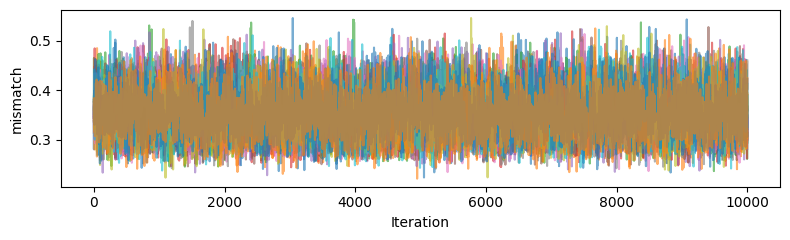

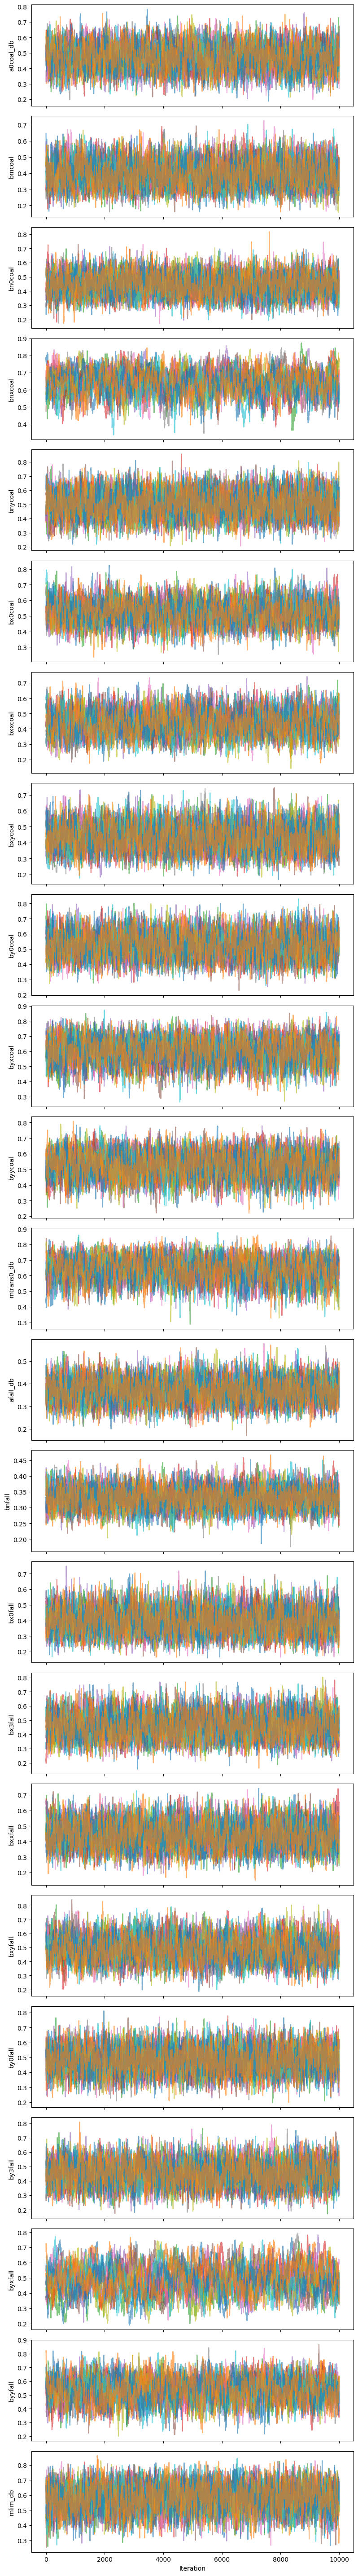

[[241.0216   242.11644  225.73999   78.695984 283.4324   132.05449
  151.7335   261.51352  215.20741  237.92023  237.6726   130.15373
  270.93457  266.88904  259.87323  237.29787  240.29332  161.40921
  277.31665  254.18518   66.14263  151.13408  279.8592   568.38635 ]
 [312.7374   229.35384  229.16649   63.884975 153.5951   128.56244
  167.71089  284.23984  167.64159  183.32431  210.59471   96.31675
  167.84445  160.81119  166.36897  239.29239  150.80724  113.21858
  355.22693  190.67714   51.826008 114.80277  241.32979  554.57965 ]
 [300.3716   132.81628  312.31192   80.815895 254.39754  151.66197
  121.79047  227.48586  220.6018   128.20274  245.15111  148.18878
  199.79478  204.38719  264.88876  248.8353   279.83752  232.31941
  348.30563  132.71762   45.38044  169.88354  231.73915  368.3183  ]
 [271.0599   272.63474  249.31511   80.32829  285.30975  103.93837
  179.23206  284.33     237.86615  224.10062  210.53558  139.59038
  231.77321  200.90257  201.83669  314.34317  186.36244 

In [30]:
print("acceptance rate:", sum(kr.inner_results.inner_results.is_accepted.numpy())/num_samples)
# param_names_incl_sigma = param_names + ['sigma']
transformed_samples = tfb.Sigmoid().forward(samples[:,:,:npar])
# transformed_samples = tf.concat([tfb.Sigmoid().forward(samples[:,:,:-1]), tf.exp(samples[:,:,-1:])], axis=2)
if samples.shape[-1]>npar:
    mf.plot_traces(np.exp(samples[:,:,npar:]), unc_names)
mf.plot_traces(transformed_samples, param_names)

print(tfp.mcmc.effective_sample_size(samples).numpy())
print(tfp.mcmc.potential_scale_reduction(samples).numpy())

In [31]:
print("acc rate:", kr.inner_results.inner_results.is_accepted.numpy().mean())
# print("step_size:", kr.inner_results.step_size.numpy())
print("step_size range:", kr.inner_results.new_step_size.numpy().min(), kr.inner_results.new_step_size.numpy().max())
# print("leapfrog steps avg:", kr.inner_results.leapfrogs_taken.numpy().mean()).
print("avg log_accept_ratio:", np.nanmean(kr.inner_results.inner_results.log_accept_ratio))

acc rate: 0.7519583333333333
step_size range: 0.043909814 0.043909814
avg log_accept_ratio: -1.2137898


In [32]:
with tf.GradientTape() as gt:
  gt.watch(initial_state)
  logprob = get_BOSSemu_lp(initial_state)
grad = gt.gradient(logprob, initial_state)
print("||grad|| ≈", tf.norm(grad).numpy())

||grad|| ≈ 267.72836


In [33]:
with tf.GradientTape() as t:
    t.watch(initial_state)                # unconstrained params you sample in
    lprob = get_BOSSemu_lp(initial_state)
g = t.gradient(lprob, initial_state)         # shape [..., D]
gn = tf.math.reduce_std(g, axis=0)  # per-dim
print(gn)

tf.Tensor(
[ 7.8924375 10.039369  12.778333   5.25315    9.585236   6.822238
  7.336137   7.375169   7.480558   5.271833   8.686341   5.9986525
  8.957009  25.91758   11.305515   8.34257    7.1161585  7.233092
 10.248099   8.34829    5.9944987  5.3522916  7.9938183 56.45019  ], shape=(24,), dtype=float32)


## postprocessing

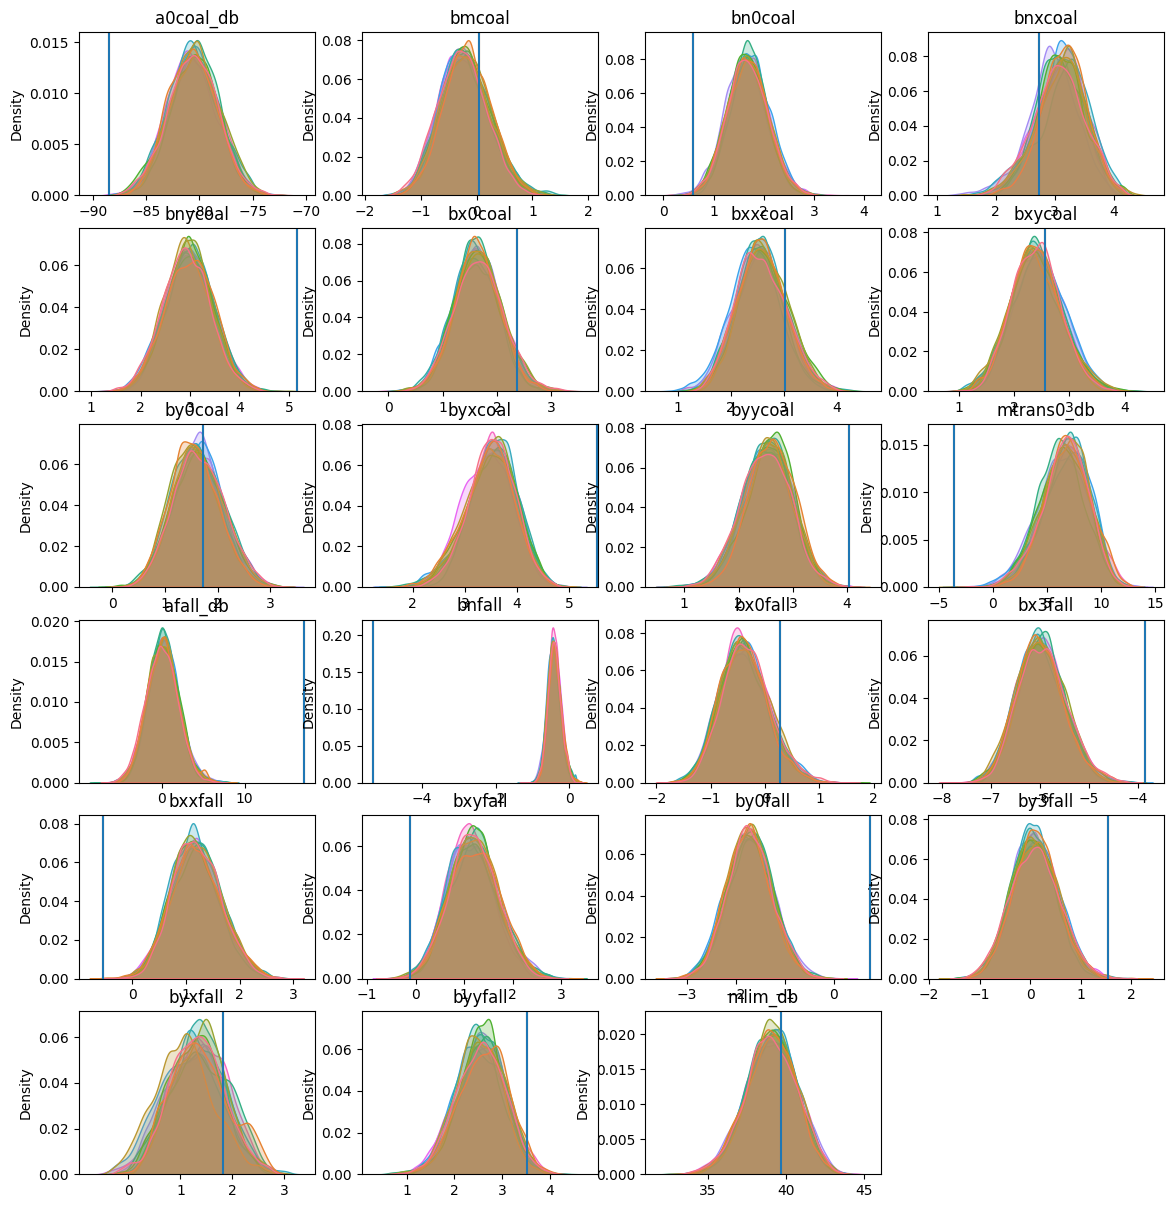

In [34]:
IC_col = tf.tile(tf.expand_dims(IC_norm[0, :n_init], 0), [num_samples, 1])
IC_col3d = tf.tile(IC_col[:, None, :], [1, nchains, 1])
samples_with_ic = tf.concat([IC_col3d, transformed_samples], axis=2)

samples_with_ic_raw_vals = np.zeros(samples_with_ic.shape, dtype=np.float32)
for ichain in range(nchains):
    samples_with_ic_raw_vals[:, ichain, :] = scalers['x'].inverse_transform(samples_with_ic[:, ichain, :])

samples_raw_vals = samples_with_ic_raw_vals[:,:,n_init:]

np.mean(samples_with_ic[:,:,n_init:].numpy().reshape(num_samples*nchains,nparam), axis=0)

samples_origval = samples_raw_vals
fig = plt.figure(figsize=(14,25))
gs = gridspec.GridSpec(10, 4)
for ipost in range(samples_origval.shape[-1]):
    param_name = param_names[ipost]
    ax = fig.add_subplot(gs[ipost])
    sns.kdeplot(samples_origval[:,:,ipost], fill=True, legend=False, ax=ax)
    plt.axvline(param_mean[ipost], color='tab:orange')
    plt.axvline(target_param_mean[ipost], color='tab:blue')
    plt.title(param_name)
plt.savefig(f'plots/{run_name}_params.png')

In [35]:
# # Corner plots using seaborn pairplot

# # Flatten all MCMC samples across chains for pairplot
# samples_flat = samples_origval.reshape(-1, samples_origval.shape[-1])

# # Create pandas DataFrame for seaborn
# df_samples = pd.DataFrame(samples_flat, columns=param_names)

# # Use seaborn's pairplot for visualizing posteriors ("corner plot")
# pairplot = sns.pairplot(
#     df_samples,
#     corner=True, # lower triangle only
#     diag_kind="kde",
#     plot_kws={"alpha": 0.15, "s": 7, "edgecolor": "none"},
# )

# pairplot.fig.suptitle("MCMC Posterior Distributions (Seaborn)", fontsize=16)
# pairplot.fig.subplots_adjust(top=0.98)
# pairplot.fig.savefig(f"plots/{run_name}_corner_seaborn.png")
# plt.show()

## validation

In [36]:
importlib.reload(ef)

<module 'emulator_fun' from '/pscratch/sd/a/arthurhu/BOSS_PPE/emulator_fun.py'>

In [37]:
# target_results = tf.cast(target_pwIC_norm, tf.float32)
# ef.plot_emulator_results(target_results, tgt_data, best_model, ppe_info, transform_method, scalers, 
#                          l_plot_uncertainty=False, l_plot_log=True, l_plot_scatter=True)

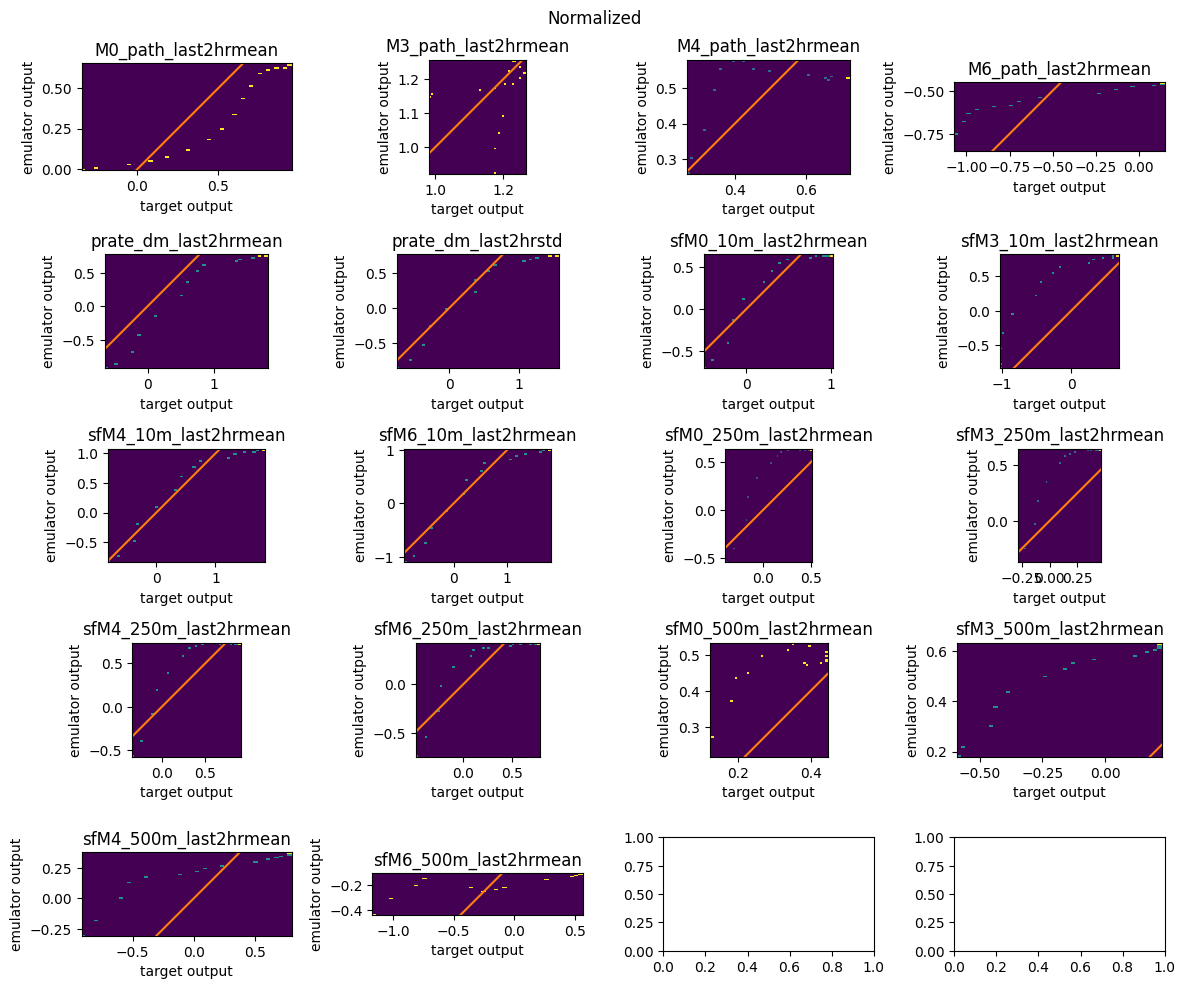

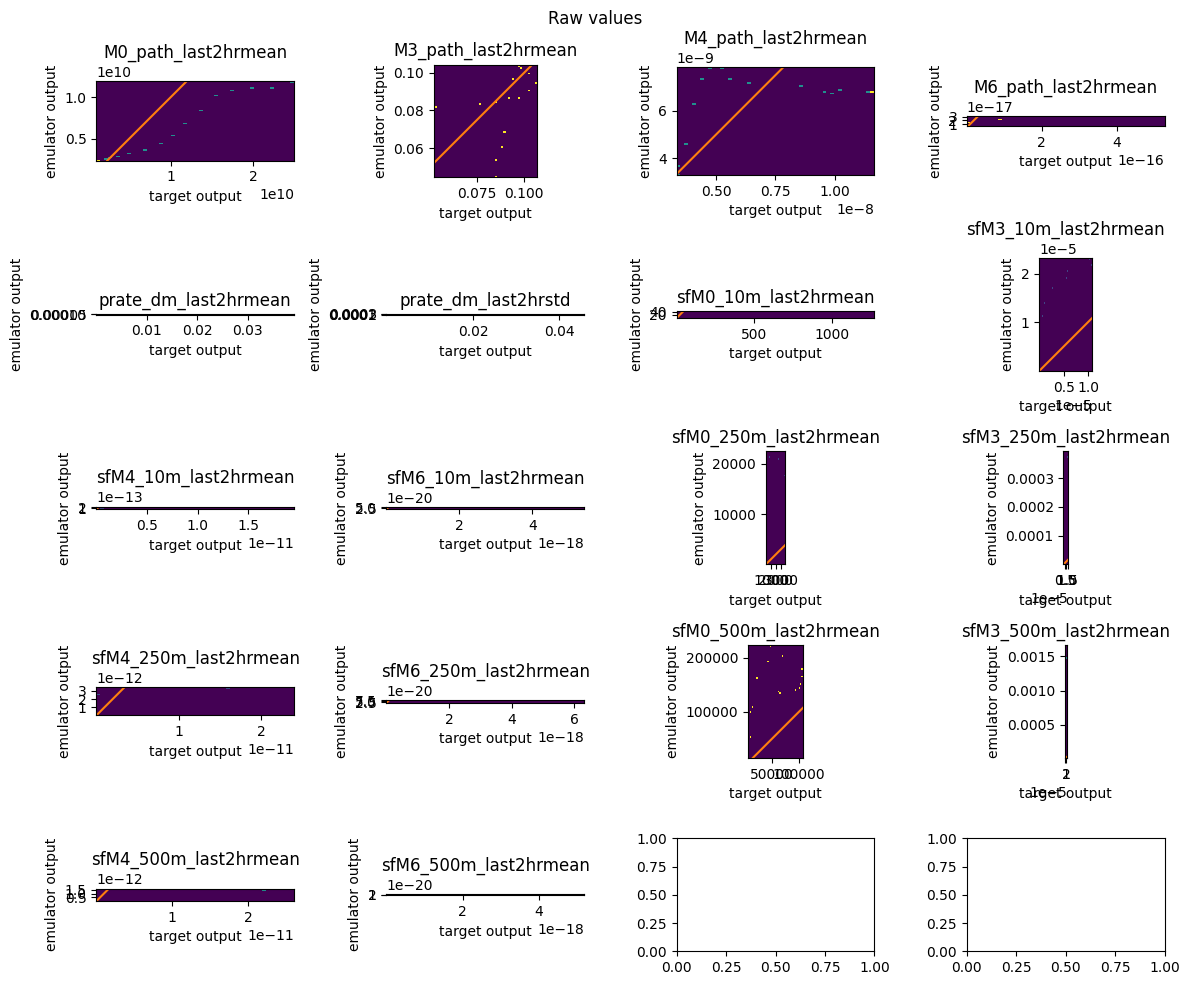

In [38]:
tsamples_combine_chains = transformed_samples.numpy().reshape(num_samples*nchains, npar)
meanresult = np.mean(tsamples_combine_chains, axis=0)
meanresult = tf.expand_dims(meanresult, axis=0)
meanresult_tiled = tf.tile(meanresult, [IC_norm.shape[0], 1])
meanresults_incl_ics = tf.concat([IC_norm, meanresult_tiled], axis=1)

ef.plot_emulator_results(meanresults_incl_ics, tgt_data, best_model, ppe_info, transform_method, scalers, 
                         l_plot_uncertainty=False, l_plot_log=False, l_plot_scatter=False)

# Save a subset of sampled parameters

In [61]:
np.random.seed(0)
n_calc_lik = 200
idx_calc_lik = np.random.choice(num_samples, size=n_calc_lik, replace=False)
arr_calc_lik = tfb.Sigmoid().forward(samples).numpy()[idx_calc_lik,0,:npar]
IC_col = tf.tile(tf.expand_dims(IC_norm[0, :n_init], 0), [n_calc_lik, 1])
samples_calc_lik = tf.concat([IC_col, arr_calc_lik], axis=1)
params_calc_lik = scalers['x'].inverse_transform(samples_calc_lik)[:,1:]

In [62]:
original_params = pd.read_csv(orig_param_csv)
# original_params.loc[3, 'a0evap1_db'] = 1

first_row = original_params.iloc[[0]]
repeated_rows = pd.concat([first_row] * n_calc_lik, ignore_index=True)
for irow in range(n_calc_lik):
    for iparam, param_name in enumerate(param_names):
        repeated_rows.loc[irow, param_name] = params_calc_lik[irow,iparam]

pd.set_option('display.max_columns',None)
repeated_rows.to_csv(f'{lp.param_dir}/samples_calc_lik_{run_name}_throw_{throw_away_ratio}.csv', index=False)

IndexError: index 12 is out of bounds for axis 1 with size 12

# Save MCMC results

## update params csv

In [39]:
sample_sum_chains = samples_origval.reshape(num_samples*nchains,nparam)

In [40]:
original_params = pd.read_csv(orig_param_csv)
updated_params = original_params.copy()
sample_mean = np.mean(sample_sum_chains, axis=0)
sample_std = np.std(sample_sum_chains, axis=0)

for iparam, param_name in enumerate(param_names):
    updated_params.loc[0, param_name] = sample_mean[iparam]
    updated_params.loc[2, param_name] = sample_std[iparam]

updated_params.to_csv(f'{lp.param_dir}/param_{run_name}_throw_{throw_away_ratio}_crps.csv', index=False)

In [41]:
pd.set_option('display.max_columns',None)
updated_params

Unnamed: 0  a0evap1_db  a0evap2_db  bm0evap1  bm0evap2  bx0evap1  bx0evap2  \
0       mean  -23.530267  -53.491215  0.006542  0.322378  2.012595  4.758512   
1         sd    2.255964    3.114923  0.003238  0.132059  0.168649  0.137407   
2        isd    2.207711    2.686361  0.003169  0.076952  0.130516  0.152637   

   by0evap1  by0evap2   aevap_db    bmevap   bx3evap   bxxevap   bxyevap  \
0  1.130926  1.087831 -69.430048  0.381905  0.018227 -1.455336 -0.167408   
1  0.390538  0.169134   0.203477  0.008552  0.076802  0.076864  0.084023   
2  0.270169  0.130546   0.656400  0.025688  0.115132  0.255519  0.154710   

    by3evap   byxevap   byyevap  a0coal_db    bmcoal   bn0coal   bnxcoal  \
0  2.848483 -0.247178 -1.579327 -80.601845 -0.213587  1.672417  3.085221   
1  0.108241  0.105786  0.100642   0.130643  0.008288  0.006519  0.006649   
2  0.265072  0.343386  0.300062   2.336447  0.443652  0.407605  0.425379   

    bnycoal   bx0coal   bxxcoal   bxycoal   by0coal   byxcoal   byycoal  \
0  2.967689  1.635689  2.561576  2.399887  1.611181  3.492048  2.523996   
1  0.006923  0.009375  0.011378  0.014938  0.012429  0.015692  0.021322   
2  0.485208  0.432767  0.467441  0.464864  0.474217  0.475509  0.453682   

   mtrans0_db  afall_db    bnfall   bx0fall   bx3fall   bxxfall   bxyfall  \
0    6.591387  0.153709 -0.414088 -0.381870 -5.985988  1.184967  1.176135   
1    0.231197  1.093249  0.220264  0.013566  0.014816  0.015543  0.019498   
2    2.190465  1.902557  0.182979  0.447686  0.488650  0.465135  0.511538   

    by0fall   by3fall   byxfall   byyfall    mlim_db  
0 -1.725925  0.092198  1.296331  2.547280  39.033840  
1  0.019935  0.021920  0.023036  0.028926   0.800699  
2  0.463801  0.460856  0.554844  0.506903   1.618143

## save posterior PDF into netCDF

In [42]:
nbins = 50
count = {}
bins = {}
for iparam, param_name in enumerate(param_names):
    count[param_name], bins[param_name] = np.histogram(sample_sum_chains[:, iparam], bins=nbins)
    count[param_name] = count[param_name]/np.sum(count[param_name])

import netCDF4 as nc
import numpy as np

# Create a new NetCDF file
ncfile = nc.Dataset(f'MCMC_posterior/{run_name}_crps_throw_{throw_away_ratio}_post.nc', mode='w', format='NETCDF4')

# Create the dimension for parameters and bins
param_dim = ncfile.createDimension('nparam', len(param_names))
binmean_dim = ncfile.createDimension('nbin', nbins)
binedge_dim = ncfile.createDimension('nbinedge', nbins+1)

# Create variables
param_var = ncfile.createVariable('param_names', str, ('nparam',))
density_var = ncfile.createVariable('density', np.float32, ('nparam', 'nbin',))
bin_edges_var = ncfile.createVariable('bin_edges', np.float32, ('nparam', 'nbinedge',))
# sigma_dens_var = ncfile.createVariable('sigma_dens', np.float32, ('nbin',))
# sigma_edge_var = ncfile.createVariable('sigma_edge', np.float32, ('nbinedge',))

# Assign data
param_var[:] = np.array(param_names, dtype='S')
for i, pname in enumerate(param_names):
    # bins[pname] has nbins+1 edges, so we store the left edges for each bin
    density_var[i, :] = count[pname]
    bin_edges_var[i, :] = bins[pname]

# sigma_dens_var[:] = count['sigma'].astype('float32')
# sigma_edge_var[:] = bins['sigma']
ncfile.close()

## save samples into arviz style netcdf output

In [43]:
with nc.Dataset(f"{lp.nc_dir}{filename}") as ds:
    param_idx_group, perturbed_pgroup = ef.get_param_interest_idx(ds, return_perturbed_groupname=True)

# Reshape samples_origval to (nchains, num_samples, nparam) if not already
# samples_origval is assumed to be (nchains, num_samples, nparam) or (num_samples, nchains, nparam)
# If it's (num_samples, nchains, nparam), transpose to (nchains, num_samples, nparam)
if samples_origval.shape[0] == nchains and samples_origval.shape[1] == num_samples:
    posterior_samples = samples_origval
elif samples_origval.shape[1] == nchains and samples_origval.shape[0] == num_samples:
    posterior_samples = np.transpose(samples_origval, (1,0,2))
else:
    posterior_samples = samples_origval.reshape(nchains, num_samples, nparam)

# Build a dict for InferenceData
iparam = 0
for igroup, (param_idx, pgname) in enumerate(zip(param_idx_group, perturbed_pgroup)):
    posterior_dict = {}
    for i, pidx in enumerate(param_idx):
        pname = all_param_names[pidx]
        # shape: (chain, draw)
        posterior_dict[pname] = posterior_samples[:,:,iparam]
        iparam += 1
    
    # Create InferenceData object
    idata = az.from_dict(posterior=posterior_dict)
    
    # Save to NetCDF
    idata.to_netcdf(f'MCMC_posterior/{run_name}_{pgname}_throw_{throw_away_ratio}_crps_posterior_arviz.nc')